In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# importing helper function from src directory
import sys, os
sys.path.append(os.path.join(os.path.dirname(__name__), '..', 'src'))

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageStat
from tqdm.auto import tqdm

from download_image import download_image
from sampling import stratified_sample_df 

In [4]:
# define dataset and image directories
DATA_DIR = "../data"
IMAGES_DIR = os.path.join(DATA_DIR, "images")

In [5]:
# Fakeddit dataset files
TRAIN_FILE = os.path.join(DATA_DIR, "multimodal_train.tsv")
VAL_FILE   = os.path.join(DATA_DIR, "multimodal_validate.tsv")
TEST_FILE  = os.path.join(DATA_DIR, "multimodal_test_public.tsv")

In [6]:
# check for CUDA availability for GPU acceleration.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [7]:
tqdm.pandas() # Enable progress bars for pandas operations

In [8]:
# load data
def load_split(path, split_name):
    df = pd.read_csv(path, sep="\t")
    df['split'] = split_name
    return df

In [9]:
# load all three dataset splits.
df_train = load_split(TRAIN_FILE, "train")
df_val   = load_split(VAL_FILE, "val")
df_test  = load_split(TEST_FILE, "test")

In [10]:
# combine all splits into a single DataFrame for easier analysis
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [11]:
print("Dataset shape:", df.shape)

Dataset shape: (682661, 17)


In [12]:
print("Columns:", df.columns.tolist())

Columns: ['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label', 'split']


In [13]:
print("Split distribution:\n", df['split'].value_counts())

Split distribution:
 split
train    564000
val       59342
test      59319
Name: count, dtype: int64


In [14]:
df.describe()

,created_utc,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label
count,6.826610e+05,479522.000000,682661.000000,479522.00000,682661.000000,682661.000000,682661.000000
mean,1.478726e+09,20.469864,399.489036,0.85539,0.393911,1.187707,1.883343
std,6.971919e+07,143.567941,3088.096838,0.11005,0.488616,0.969689,1.782152
min,1.212297e+09,0.000000,-950.000000,0.50000,0.000000,0.000000,0.000000
25%,1.418136e+09,1.000000,5.000000,0.78000,0.000000,0.000000,0.000000
50%,1.489024e+09,2.000000,14.000000,0.88000,0.000000,2.000000,2.000000
75%,1.550487e+09,7.000000,46.000000,0.94000,1.000000,2.000000,4.000000
max,1.573859e+09,17355.000000,137179.000000,1.00000,1.000000,2.000000,5.000000


In [15]:
df.isnull().sum()

author                   34841
clean_title                  0
created_utc                  0
domain                  203139
hasImage                     0
id                           0
image_url                 1863
linked_submission_id    479522
num_comments            203139
score                        0
subreddit                    0
title                        0
upvote_ratio            203139
2_way_label                  0
3_way_label                  0
6_way_label                  0
split                        0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682661 entries, 0 to 682660
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                647820 non-null  object 
 1   clean_title           682661 non-null  object 
 2   created_utc           682661 non-null  float64
 3   domain                479522 non-null  object 
 4   hasImage              682661 non-null  bool   
 5   id                    682661 non-null  object 
 6   image_url             680798 non-null  object 
 7   linked_submission_id  203139 non-null  object 
 8   num_comments          479522 non-null  float64
 9   score                 682661 non-null  int64  
 10  subreddit             682661 non-null  object 
 11  title                 682661 non-null  object 
 12  upvote_ratio          479522 non-null  float64
 13  2_way_label           682661 non-null  int64  
 14  3_way_label           682661 non-null  int64  
 15  

In [17]:
# MODALITY PRESENCE
df['has_image'] = df[['image_url']].notna()
df['has_text']  = df[['clean_title']].apply(lambda r: any(pd.notna(x) and str(x).strip()!="" for x in r), axis=1)
df['both']      = df['has_image'] & df['has_text']

In [18]:
print("Modality counts:\n", df[['has_image','has_text','both']].sum())

Modality counts:
 has_image    680798
has_text     682661
both         680798
dtype: int64


In [19]:
label_cols = ['2_way_label', '3_way_label', '6_way_label']

In [20]:
# check label distributions
for col in label_cols:
    if col in df.columns:
        print(f"\nDistribution of {col}:")
        print(df[col].value_counts())


Distribution of 2_way_label:
2_way_label
0    413753
1    268908
Name: count, dtype: int64

Distribution of 3_way_label:
3_way_label
2    397048
0    268908
1     16705
Name: count, dtype: int64

Distribution of 6_way_label:
6_way_label
0    268908
4    203139
2    129795
1     40516
5     26057
3     14246
Name: count, dtype: int64


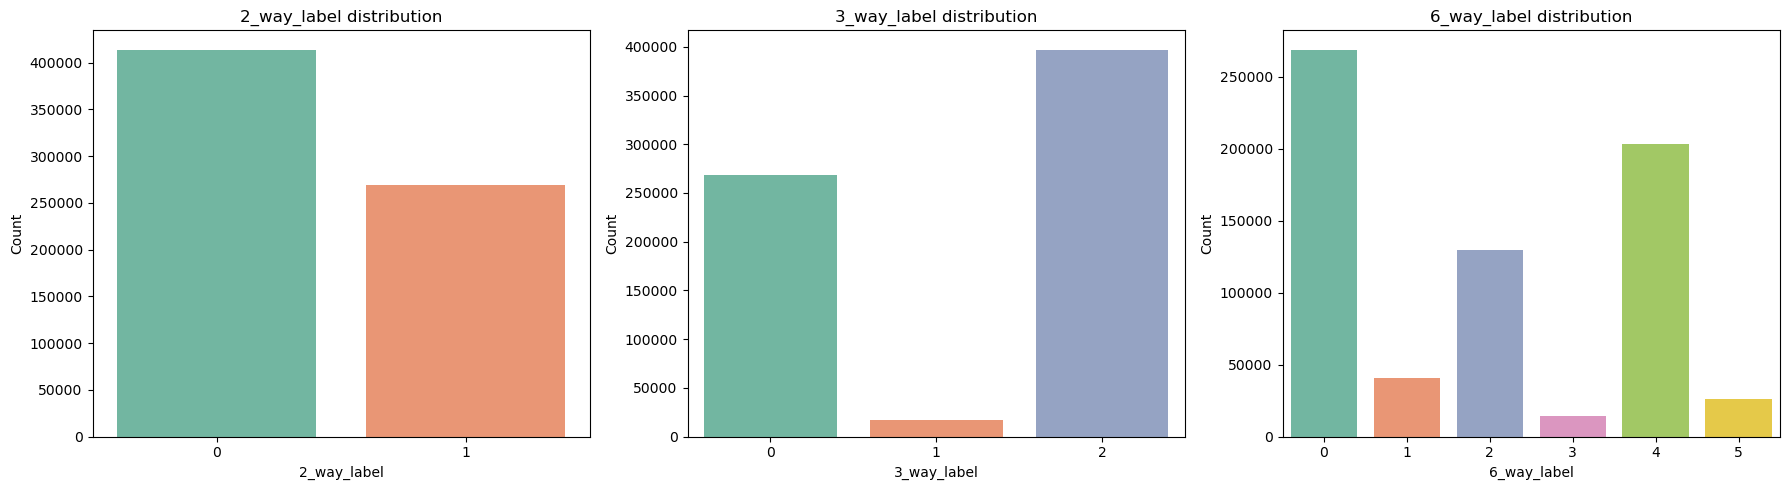

In [21]:
# plot distributions
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, col in enumerate(label_cols):
    if col in df.columns:
        sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
        axes[i].set_title(f"{col} distribution")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [22]:
# text analysis
df['token_count']   = df['clean_title'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)

In [23]:
print("Token count stats:\n", df['token_count'].describe())

Token count stats:
 count    682661.000000
mean          7.456254
std           5.631392
min           1.000000
25%           3.000000
50%           6.000000
75%          10.000000
max         553.000000
Name: token_count, dtype: float64


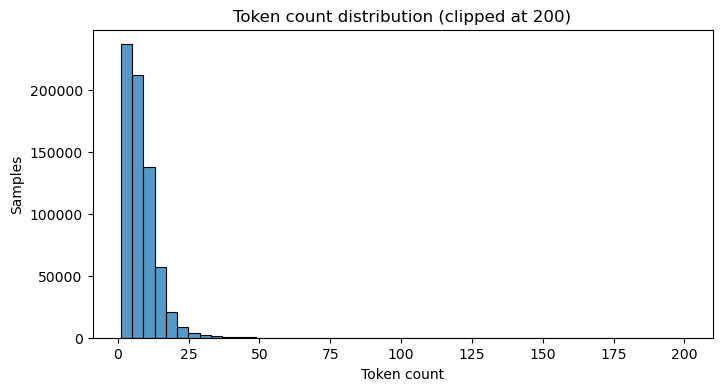

In [24]:
plt.figure(figsize=(8,4))
sns.histplot(df['token_count'].clip(0,200), bins=50)
plt.title("Token count distribution (clipped at 200)")
plt.xlabel("Token count"); plt.ylabel("Samples")
plt.show()

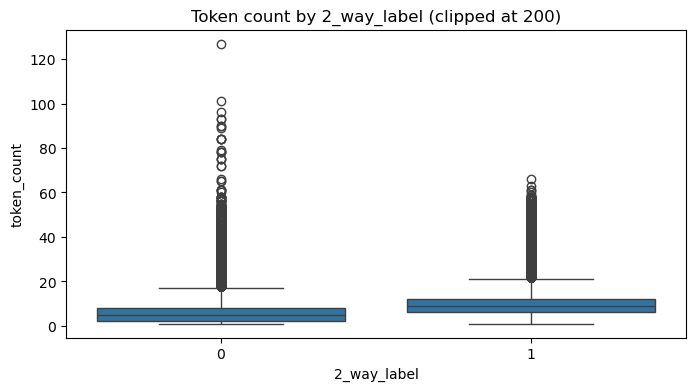

In [25]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df[df['token_count']<200], x='2_way_label', y='token_count')
plt.title("Token count by 2_way_label (clipped at 200)")
plt.show()

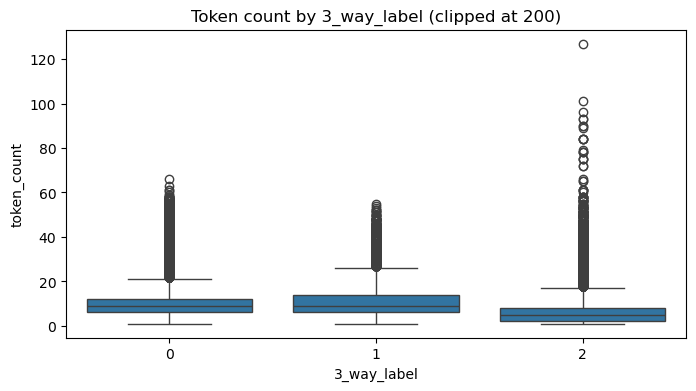

In [26]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df[df['token_count']<200], x='3_way_label', y='token_count')
plt.title("Token count by 3_way_label (clipped at 200)")
plt.show()

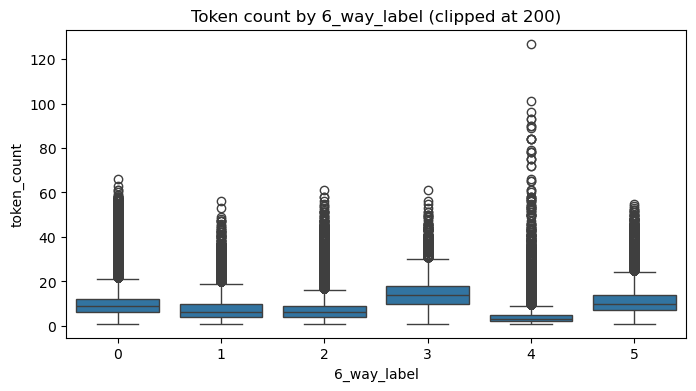

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df[df['token_count']<200], x='6_way_label', y='token_count')
plt.title("Token count by 6_way_label (clipped at 200)")
plt.show()

In [28]:
def top_n_tokens(series, n=15):
    token_freq = {}
    for s in series.dropna().astype(str):
        for token in s.split():
            token_freq[token] = token_freq.get(token, 0) + 1
    # sort by frequency (descending) and take top n
    sorted_tokens = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_tokens[:n]

In [29]:
print("Top tokens (fake):", top_n_tokens(df[df['2_way_label']==0]['clean_title']))

Top tokens (fake): [('the', 113077), ('a', 64632), ('of', 54204), ('to', 46359), ('in', 36629), ('this', 33179), ('i', 27914), ('is', 24219), ('and', 23013), ('my', 21091), ('on', 20751), ('you', 20551), ('for', 19392), ('it', 15309), ('with', 13895)]


In [30]:
print("Top tokens (real):", top_n_tokens(df[df['2_way_label']==1]['clean_title']))

Top tokens (real): [('a', 86610), ('the', 83537), ('in', 60844), ('this', 58275), ('to', 50027), ('of', 49708), ('my', 33019), ('on', 32116), ('and', 25630), ('for', 24738), ('with', 22129), ('at', 18561), ('i', 17488), ('is', 16031), ('from', 15325)]


In [31]:
# sample a subset for image analysis
SAMPLE_IMG_DOWNLOAD = 50
sample_df = df.sample(n=min(SAMPLE_IMG_DOWNLOAD, len(df)), random_state=42)
downloaded = 0

for _, row in sample_df.iterrows():
    if row["hasImage"] == True and row["image_url"] != "" and row["image_url"] != "nan":
        url = row.get('image_url')
        #print(url)
        try:
            urllib.request.urlretrieve(url, os.path.join(IMAGES_DIR,f"{row.get('id','idx')}.jpg"))
            downloaded += 1
        except Exception as e:
            #print(e)
            continue

print("Downloaded:", downloaded, "images")

Downloaded: 31 images


In [32]:
# --- 2. Data Sampling and Download Execution ---

# Define the sampling ratios
TRAIN_RATIO = 0.01  # Use 1% of the train data
VAL_RATIO = 0.01     # Use 1% of the original validation set
TEST_RATIO = 0.01    # Use 1% of the original test set

print("--- Data Sampling ---")
df_train_sampled = stratified_sample_df(df_train, TRAIN_RATIO)
df_val_sampled = stratified_sample_df(df_val, VAL_RATIO)
df_test_sampled = stratified_sample_df(df_test, TEST_RATIO)

# Combine for easier iteration, then process
all_dfs = [df_train_sampled, df_val_sampled, df_test_sampled]
df_names = ['df_train_sampled', 'df_val_sampled', 'df_test_sampled']

--- Data Sampling ---


In [33]:
# 2.1 Filter for Multimodal Examples & Clean Text
# Only keep rows that originally had an image and clean the title.
for df in all_dfs:
    df.loc[:, 'clean_title'] = df['clean_title'].fillna("")
    df.loc[:, 'image_downloaded'] = False
    
df_train_multimodal = df_train_sampled[df_train_sampled['hasImage'] == True].copy()
df_val_multimodal = df_val_sampled[df_val_sampled['hasImage'] == True].copy()
df_test_multimodal = df_test_sampled[df_test_sampled['hasImage'] == True].copy()

In [34]:
# 2.2 Download Images and Filter
print("\n--- Downloading Images and Filtering (Rows where download fails will be dropped) ---")
for df, name in zip([df_train_multimodal, df_val_multimodal, df_test_multimodal], 
                    ['Train', 'Validation', 'Test']):
    
    print(f"Starting download attempt for {name} ({len(df)} samples)...")
    # Apply the download function and store success status
    df['image_downloaded'] = df.progress_apply(
        lambda row: download_image(row, IMAGES_DIR), axis=1
    )
    
    initial_count = len(df)
    # Drop rows where the download failed (image_downloaded == False)
    df.drop(df[df['image_downloaded'] == False].index, inplace=True)
    
    print(f"{name} split filtered: {len(df)} remaining / {initial_count} initial (Dropped {initial_count - len(df)} failed downloads)")

# Assign filtered DataFrames back to shorter names
df_train_sim = df_train_multimodal.copy()
df_val_sim = df_val_multimodal.copy()
df_test_sim = df_test_multimodal.copy()


--- Downloading Images and Filtering (Rows where download fails will be dropped) ---
Starting download attempt for Train (563 samples)...


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [01:40<00:00,  5.62it/s]


Train split filtered: 544 remaining / 563 initial (Dropped 19 failed downloads)
Starting download attempt for Validation (592 samples)...


100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [01:46<00:00,  5.58it/s]


Validation split filtered: 569 remaining / 592 initial (Dropped 23 failed downloads)
Starting download attempt for Test (592 samples)...


100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [01:59<00:00,  4.94it/s]

Test split filtered: 565 remaining / 592 initial (Dropped 27 failed downloads)


In [36]:
if len(df_train_sim) == 0:
    raise ValueError("The training set is empty after image download/filtering. Try a higher TRAIN_RATIO.")